In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr
from sklearn.inspection import plot_partial_dependence
from yellowbrick.regressor import residuals_plot, ResidualsPlot, PredictionError
from yellowbrick.model_selection import FeatureImportances
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
data = pd.read_csv("core_indicators.csv")
data.head()
data.shape

C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (30,32,46,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(38118, 61)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38118 entries, 0 to 38117
Data columns (total 61 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country_name                      38118 non-null  object 
 1   region_name                       19796 non-null  object 
 2   estab_size                        38118 non-null  object 
 3   sector                            38118 non-null  object 
 4   single_or_multi_site              38118 non-null  object 
 5   estab_type                        38118 non-null  object 
 6   weight_base                       38118 non-null  float64
 7   has_trained_base                  38118 non-null  float64
 8   sample_size                       38118 non-null  int64  
 9   sample_size_w_vac                 38118 non-null  object 
 10  time_period                       38118 non-null  int64  
 11  time_identifier                   38118 non-null  object 
 12  geog

In [4]:
# To drop irrelevant columns

columns_to_drop = ['country_name', 'region_name', 'estab_size', 'sample_size', 
          'sample_size_w_vac', 'time_period', 'time_identifier',
          'geographic_level', 'region_code', 'country_code', 'has_skillgap']
data = data.drop(columns = columns_to_drop)

In [5]:
# To check for missing values
nan_check = data.isna().any().any()
nan_check

False

array([[<AxesSubplot:title={'center':'weight_base'}>,
        <AxesSubplot:title={'center':'has_trained_base'}>,
        <AxesSubplot:title={'center':'has_vac'}>,
        <AxesSubplot:title={'center':'has_htfv'}>,
        <AxesSubplot:title={'center':'has_ssv'}>,
        <AxesSubplot:title={'center':'skillgaps'}>],
       [<AxesSubplot:title={'center':'employees'}>,
        <AxesSubplot:title={'center':'trainees'}>,
        <AxesSubplot:title={'center':'training_days'}>,
        <AxesSubplot:title={'center':'has_offthejob_training'}>,
        <AxesSubplot:title={'center':'has_onthejob_training'}>,
        <AxesSubplot:title={'center':'has_onthejob_training_only'}>],
       [<AxesSubplot:title={'center':'has_training_in_general'}>,
        <AxesSubplot:title={'center':'has_basic_induction_training'}>,
        <AxesSubplot:title={'center':'has_health_safety_training'}>,
        <AxesSubplot:title={'center':'has_job_specific_training'}>,
        <AxesSubplot:title={'center':'has_superviso

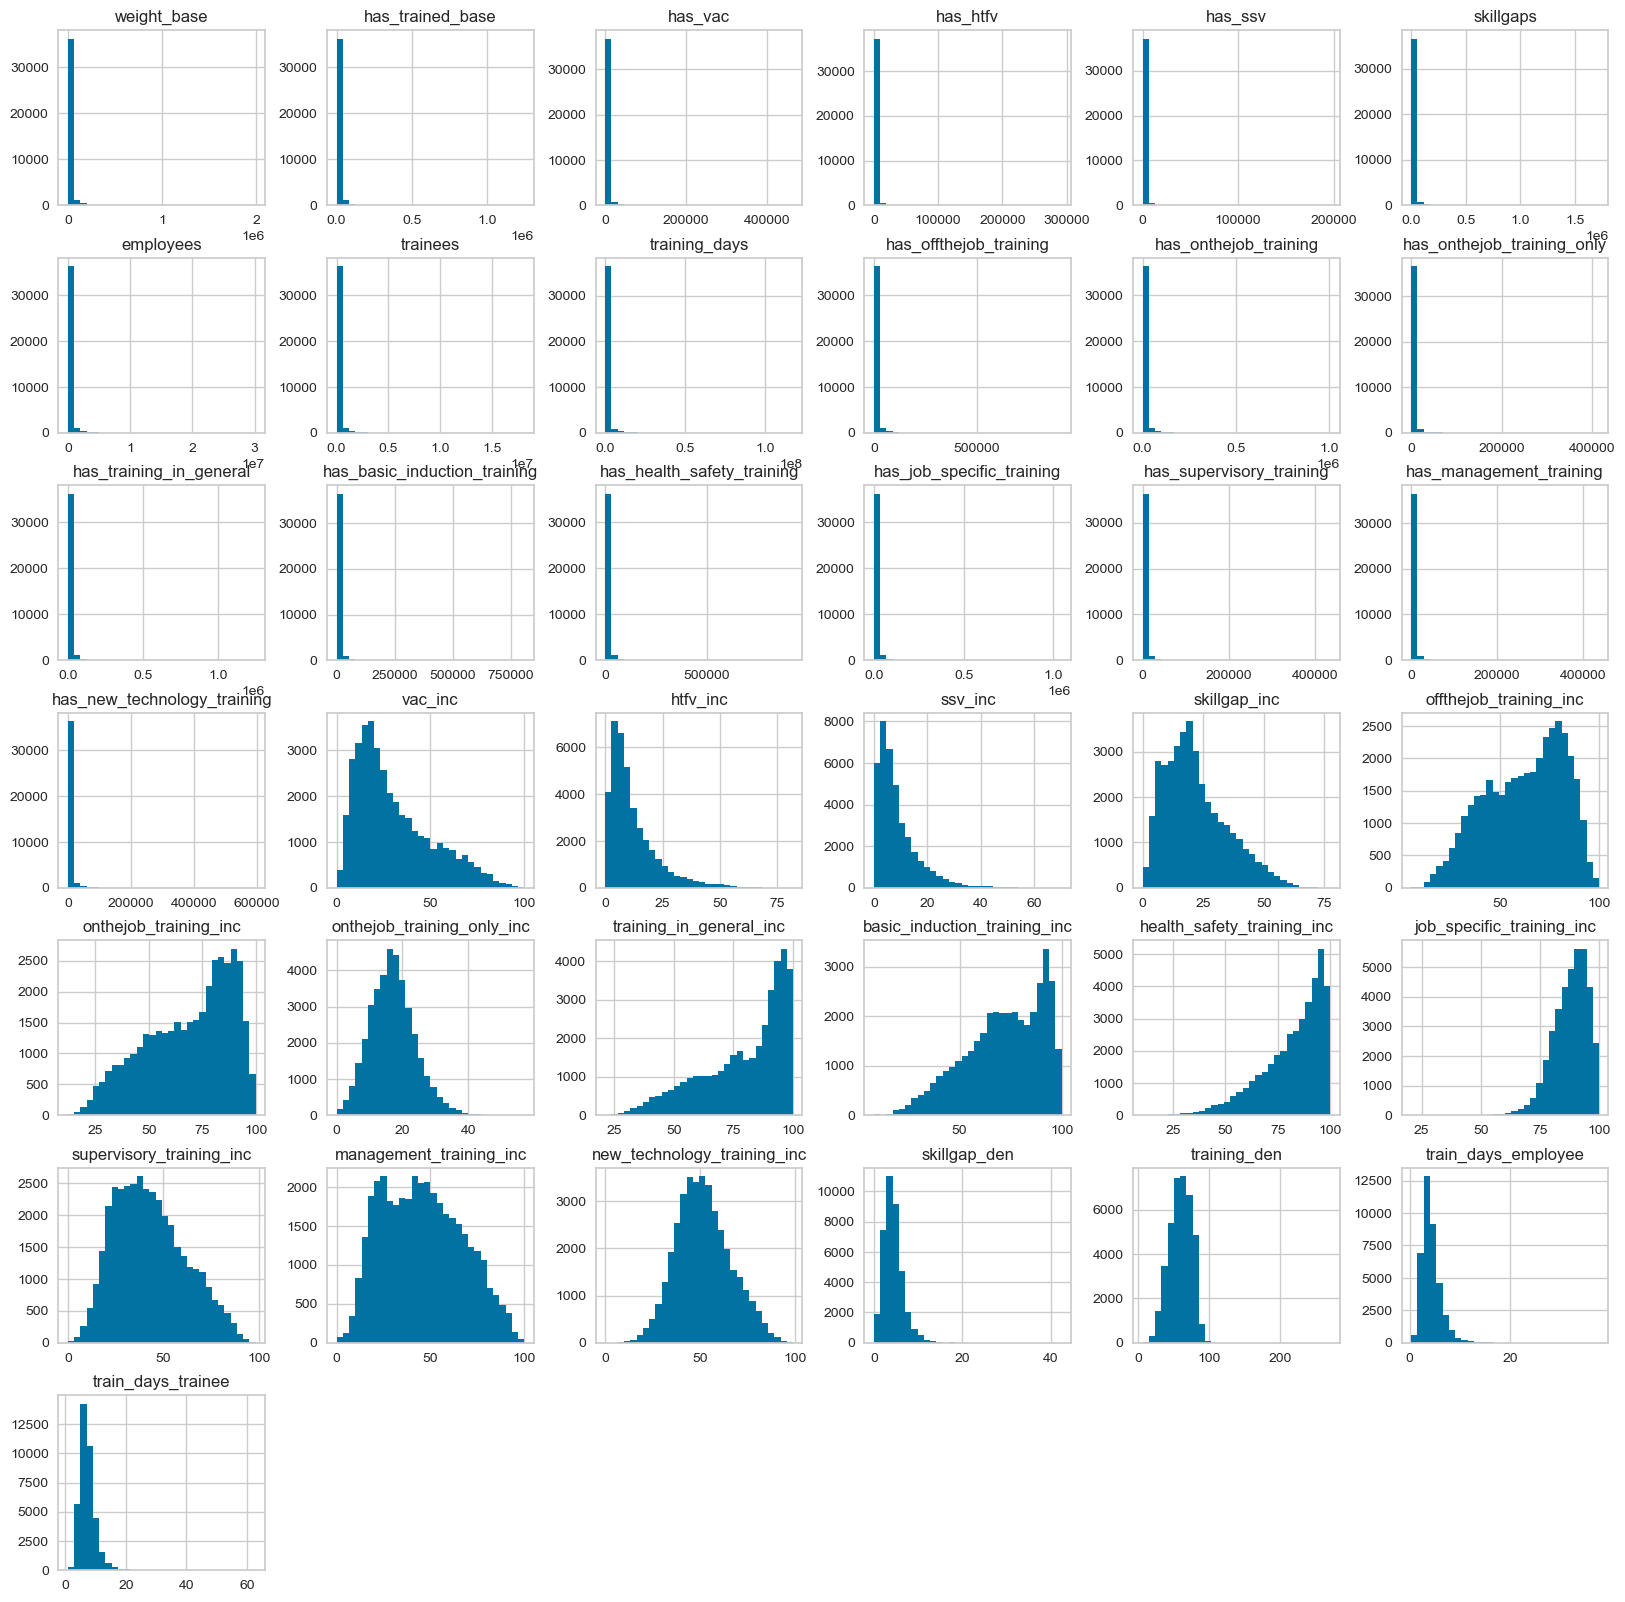

In [6]:
# To plot the distributio of data
data.hist(bins=30, figsize=(20,20))

In [7]:
# To handle missing values
col_names = ['vac_sum' , 'htfv_sum', 'ssv_sum', 'has_e_learning', 'has_extensive_induction_training', 
             'e_learning_inc','extensive_induction_training_inc', 'vac_den', 'htfv_den','ssv_den']

data[col_names] = data[col_names].replace({'x': np.nan, 'u': np.nan})

# To convert the columns to numeric
for col_name in col_names:
    data[col_name] = pd.to_numeric(data[col_name], errors='coerce')

# To impute the missing values based on their distribution
for col_name in col_names:
    # To check if the column is numeric
    if data[col_name].dtype == 'float64' or data[col_name].dtype == 'int64':
        # To check for the skewness of the data
        if abs(data[col_name].skew()) > 1:  # Highly skewed
            # If highly skewed, replace with median
            median_value = data[col_name].median()
            data[col_name].fillna(median_value, inplace=True)
        else:  
            # To impute mean for symmetrically distributed data
            mean_value = data[col_name].mean()
            data[col_name].fillna(mean_value, inplace=True)
    else:
        # To impute mode for categorical data
        mode_value = data[col_name].mode(dropna=True)[0]
        data[col_name].fillna(mode_value, inplace=True)

In [8]:
# To make a copy of original dataframe
data_copy = data.copy()

# Label Encoding
label_encoder = LabelEncoder() # Create an instance for label encoder
categorical_columns = ['estab_type', 'single_or_multi_site', 'sector'] 
# To apply label encoding for categorical column
for col in categorical_columns:
    data_copy[col] = label_encoder.fit_transform(data[col])
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38118 entries, 0 to 38117
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   sector                            38118 non-null  int32  
 1   single_or_multi_site              38118 non-null  int32  
 2   estab_type                        38118 non-null  int32  
 3   weight_base                       38118 non-null  float64
 4   has_trained_base                  38118 non-null  float64
 5   has_vac                           38118 non-null  float64
 6   has_htfv                          38118 non-null  float64
 7   has_ssv                           38118 non-null  float64
 8   vac_sum                           38118 non-null  float64
 9   htfv_sum                          38118 non-null  float64
 10  ssv_sum                           38118 non-null  float64
 11  skillgaps                         38118 non-null  float64
 12  empl

Strongly Correlated Features with Skill Gap Incidence:
vac_inc and skillgap_inc: 0.74
htfv_inc and skillgap_inc: 0.55
ssv_inc and skillgap_inc: 0.59
offthejob_training_inc and skillgap_inc: 0.61
onthejob_training_inc and skillgap_inc: 0.67
training_in_general_inc and skillgap_inc: 0.64
basic_induction_training_inc and skillgap_inc: 0.72
extensive_induction_training_inc and skillgap_inc: 0.55
health_safety_training_inc and skillgap_inc: 0.60
job_specific_training_inc and skillgap_inc: 0.57
supervisory_training_inc and skillgap_inc: 0.73
management_training_inc and skillgap_inc: 0.68
skillgap_den and skillgap_inc: 0.57

Weakly Correlated Features with Skill Gap Incidence:
e_learning_inc and skillgap_inc: 0.36
new_technology_training_inc and skillgap_inc: 0.39
training_den and skillgap_inc: 0.25


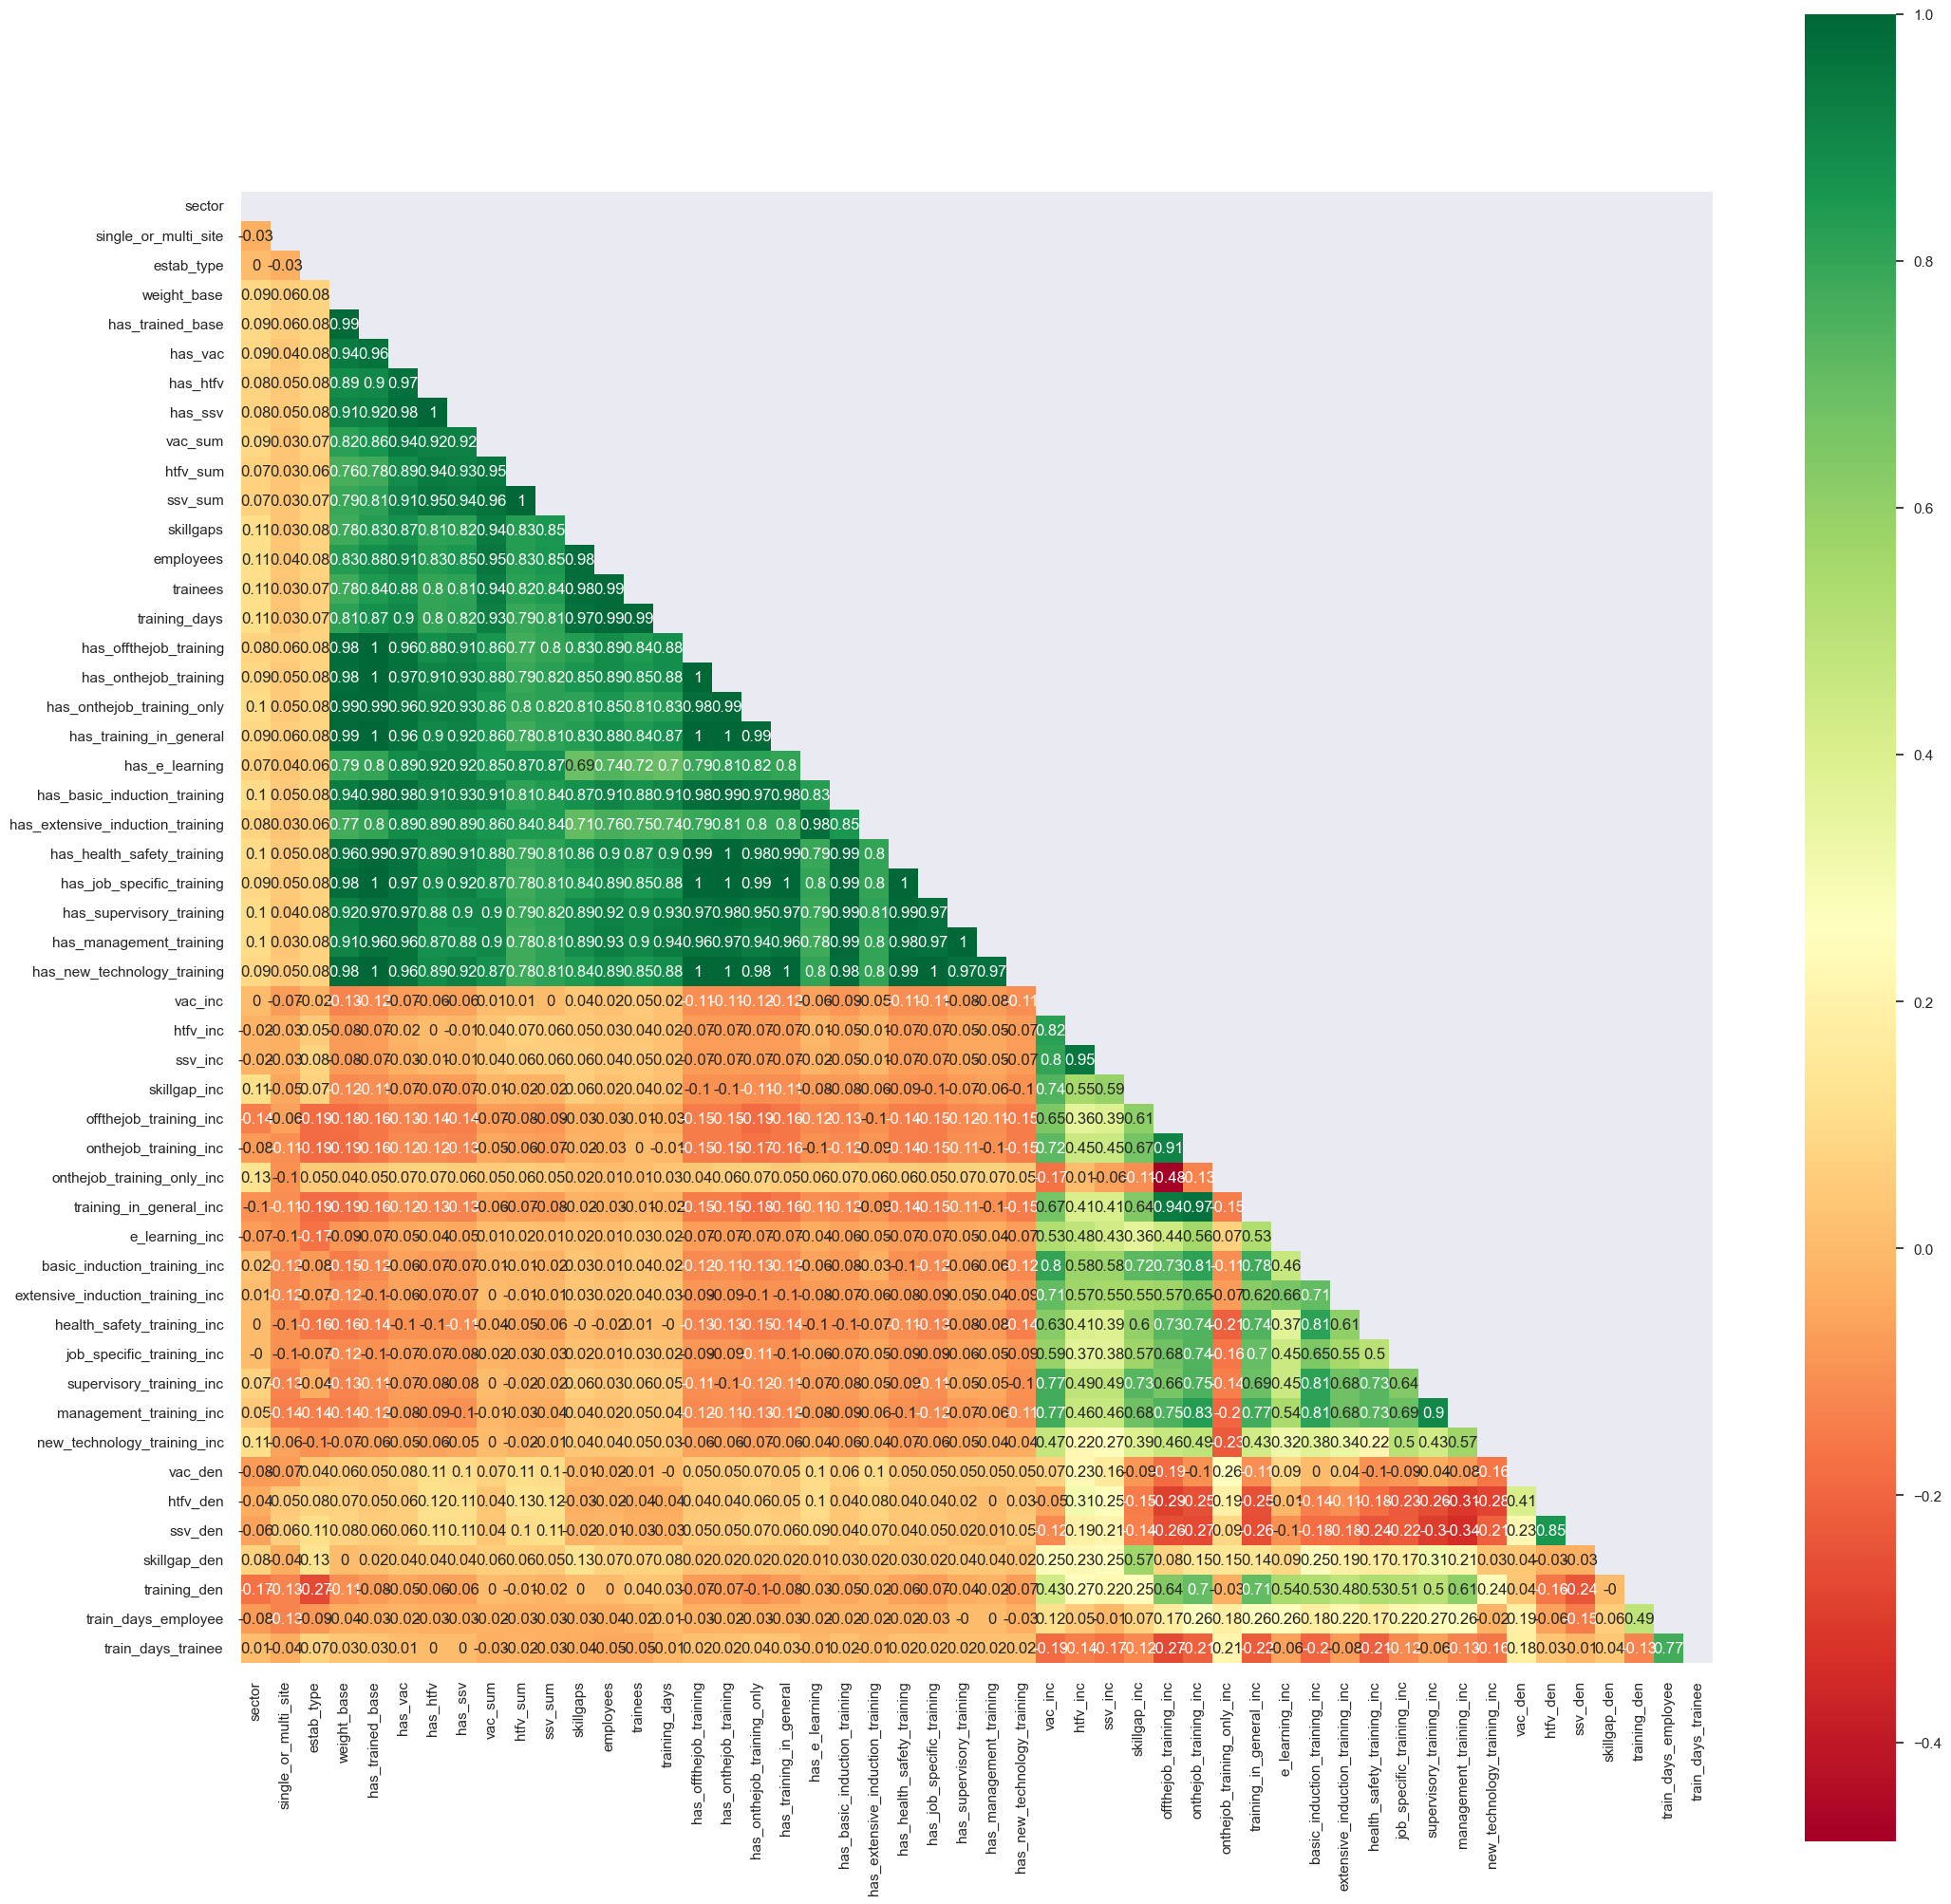

In [9]:
sns.set(rc={'figure.figsize':(25, 25)})

# To create a mask to hide Upper Triangle
mask = np.triu(np.ones_like(data_copy.corr(), dtype=bool))

# To create a heatmap
sns.heatmap(data_copy.corr().round(2), square=True, cmap='RdYlGn', annot=True, mask=mask)
# Print Strong Correlations with Skill Gap Density
strong_corr_skill_gap = data_copy.corr()['skillgap_inc'].round(2).abs() > 0.5  # Adjust the threshold as needed
strong_corr_pairs_skill_gap = [(col, 'skillgap_inc') for col in strong_corr_skill_gap.index if col != 'skillgap_inc' and strong_corr_skill_gap.loc[col]]
print("Strongly Correlated Features with Skill Gap Incidence:")
for pair in strong_corr_pairs_skill_gap:
    corr_value = data_copy.corr().loc[pair[0], 'skillgap_inc']
    print(f"{pair[0]} and {pair[1]}: {corr_value:.2f}")

# Print Weak Correlations with Skill Gap Density
weak_corr_skill_gap = (data_copy.corr()['skillgap_inc'].round(2).abs() > 0.2) & (data_copy.corr()['skillgap_inc'].round(2).abs() <= 0.5)  # Adjust the thresholds as needed
weak_corr_pairs_skill_gap = [(col, 'skillgap_inc') for col in weak_corr_skill_gap.index if col != 'skillgap_inc' and weak_corr_skill_gap.loc[col]]
print("\nWeakly Correlated Features with Skill Gap Incidence:")
for pair in weak_corr_pairs_skill_gap:
    corr_value = data_copy.corr().loc[pair[0], 'skillgap_inc']
    print(f"{pair[0]} and {pair[1]}: {corr_value:.2f}")

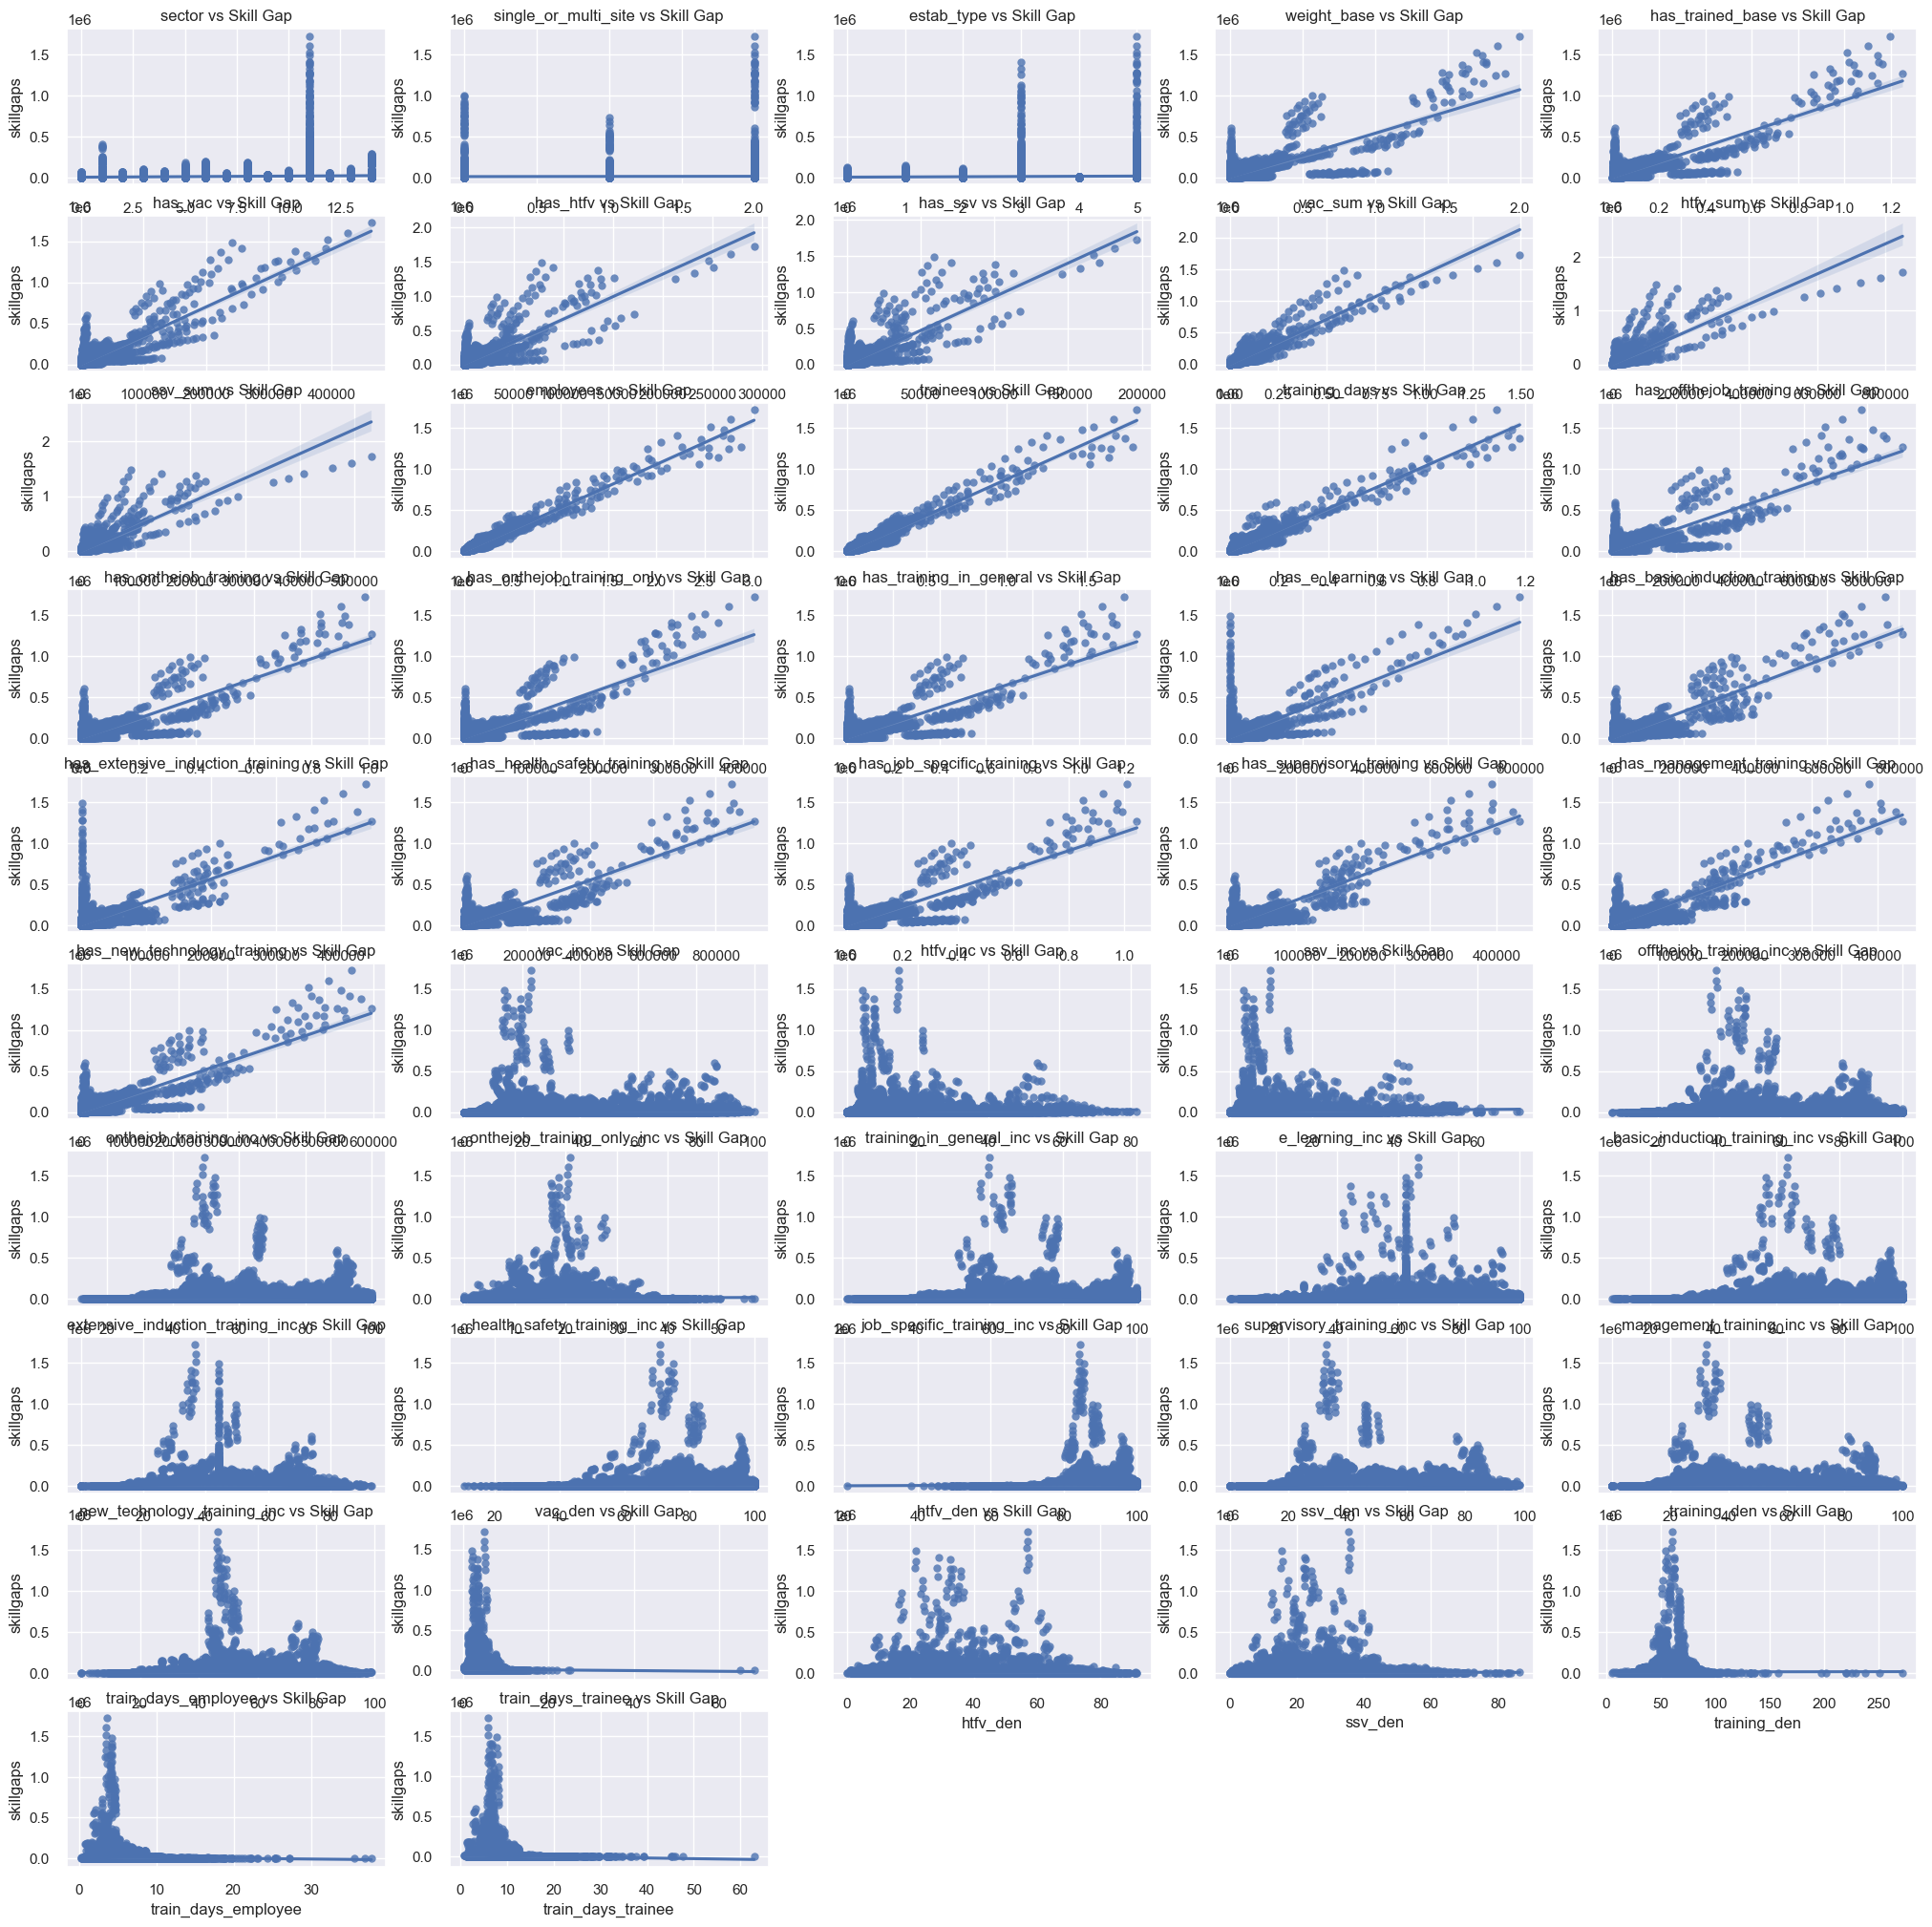

In [10]:
# To Select all predictor features 
X = data_copy.drop(['skillgaps', 'skillgap_inc', 'skillgap_den'], axis=1)

# To Select the target features 
y = data_copy[['skillgaps', 'skillgap_inc', 'skillgap_den']]
y1= data_copy['skillgaps']
y2= data_copy['skillgap_inc']
y3= data_copy['skillgap_den']
              
# To plot the relationship between predictors and Skill Gap
plt.figure(figsize=(25, 25))
num_features = len(X.columns)
num_rows = math.ceil(num_features / 5)
num_cols = min(5, num_features)  
for i, col in enumerate(X.columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.regplot(x=col, y=y1, data=data_copy)
    plt.title("%s vs Skill Gap" %(col))

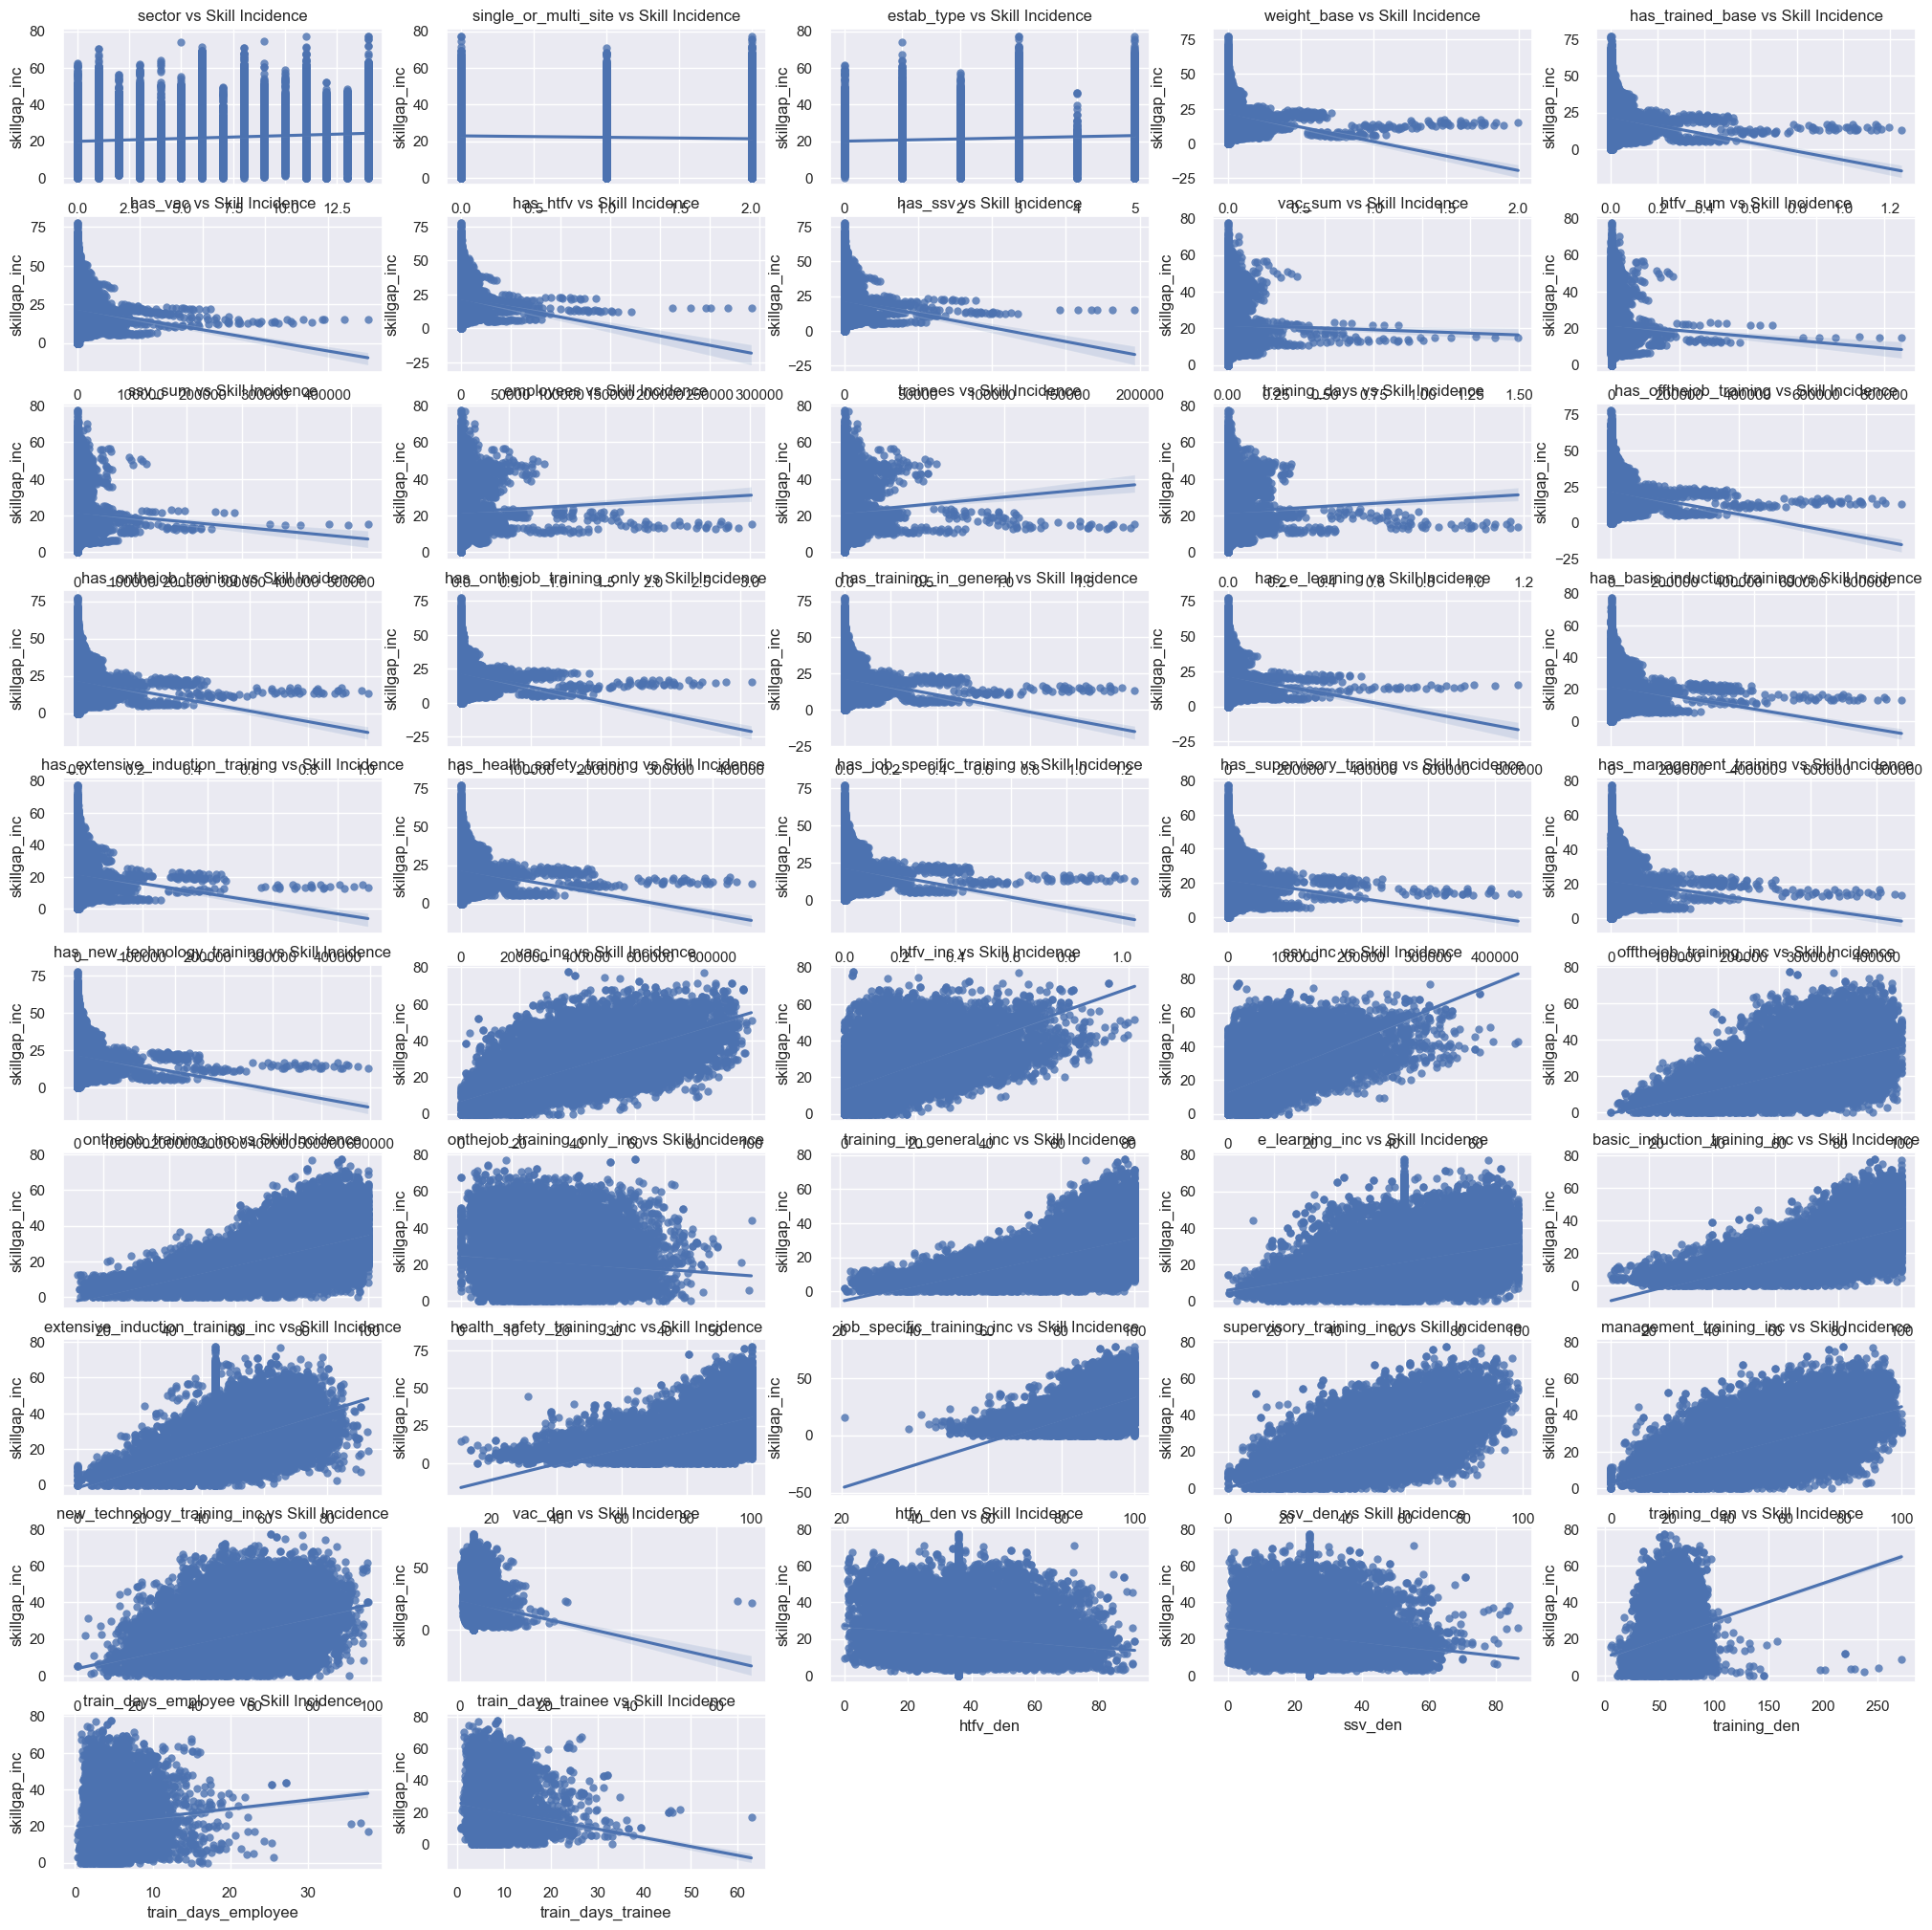

In [11]:
# To plot the relationship between predictors and Skill Gap Incidence
plt.figure(figsize=(25, 25))
num_features = len(X.columns)
num_rows = math.ceil(num_features / 5)
num_cols = min(5, num_features) 
for i, col in enumerate(X.columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.regplot(x=col, y=y2, data=data_copy)
    plt.title("%s vs Skill Incidence" %(col))

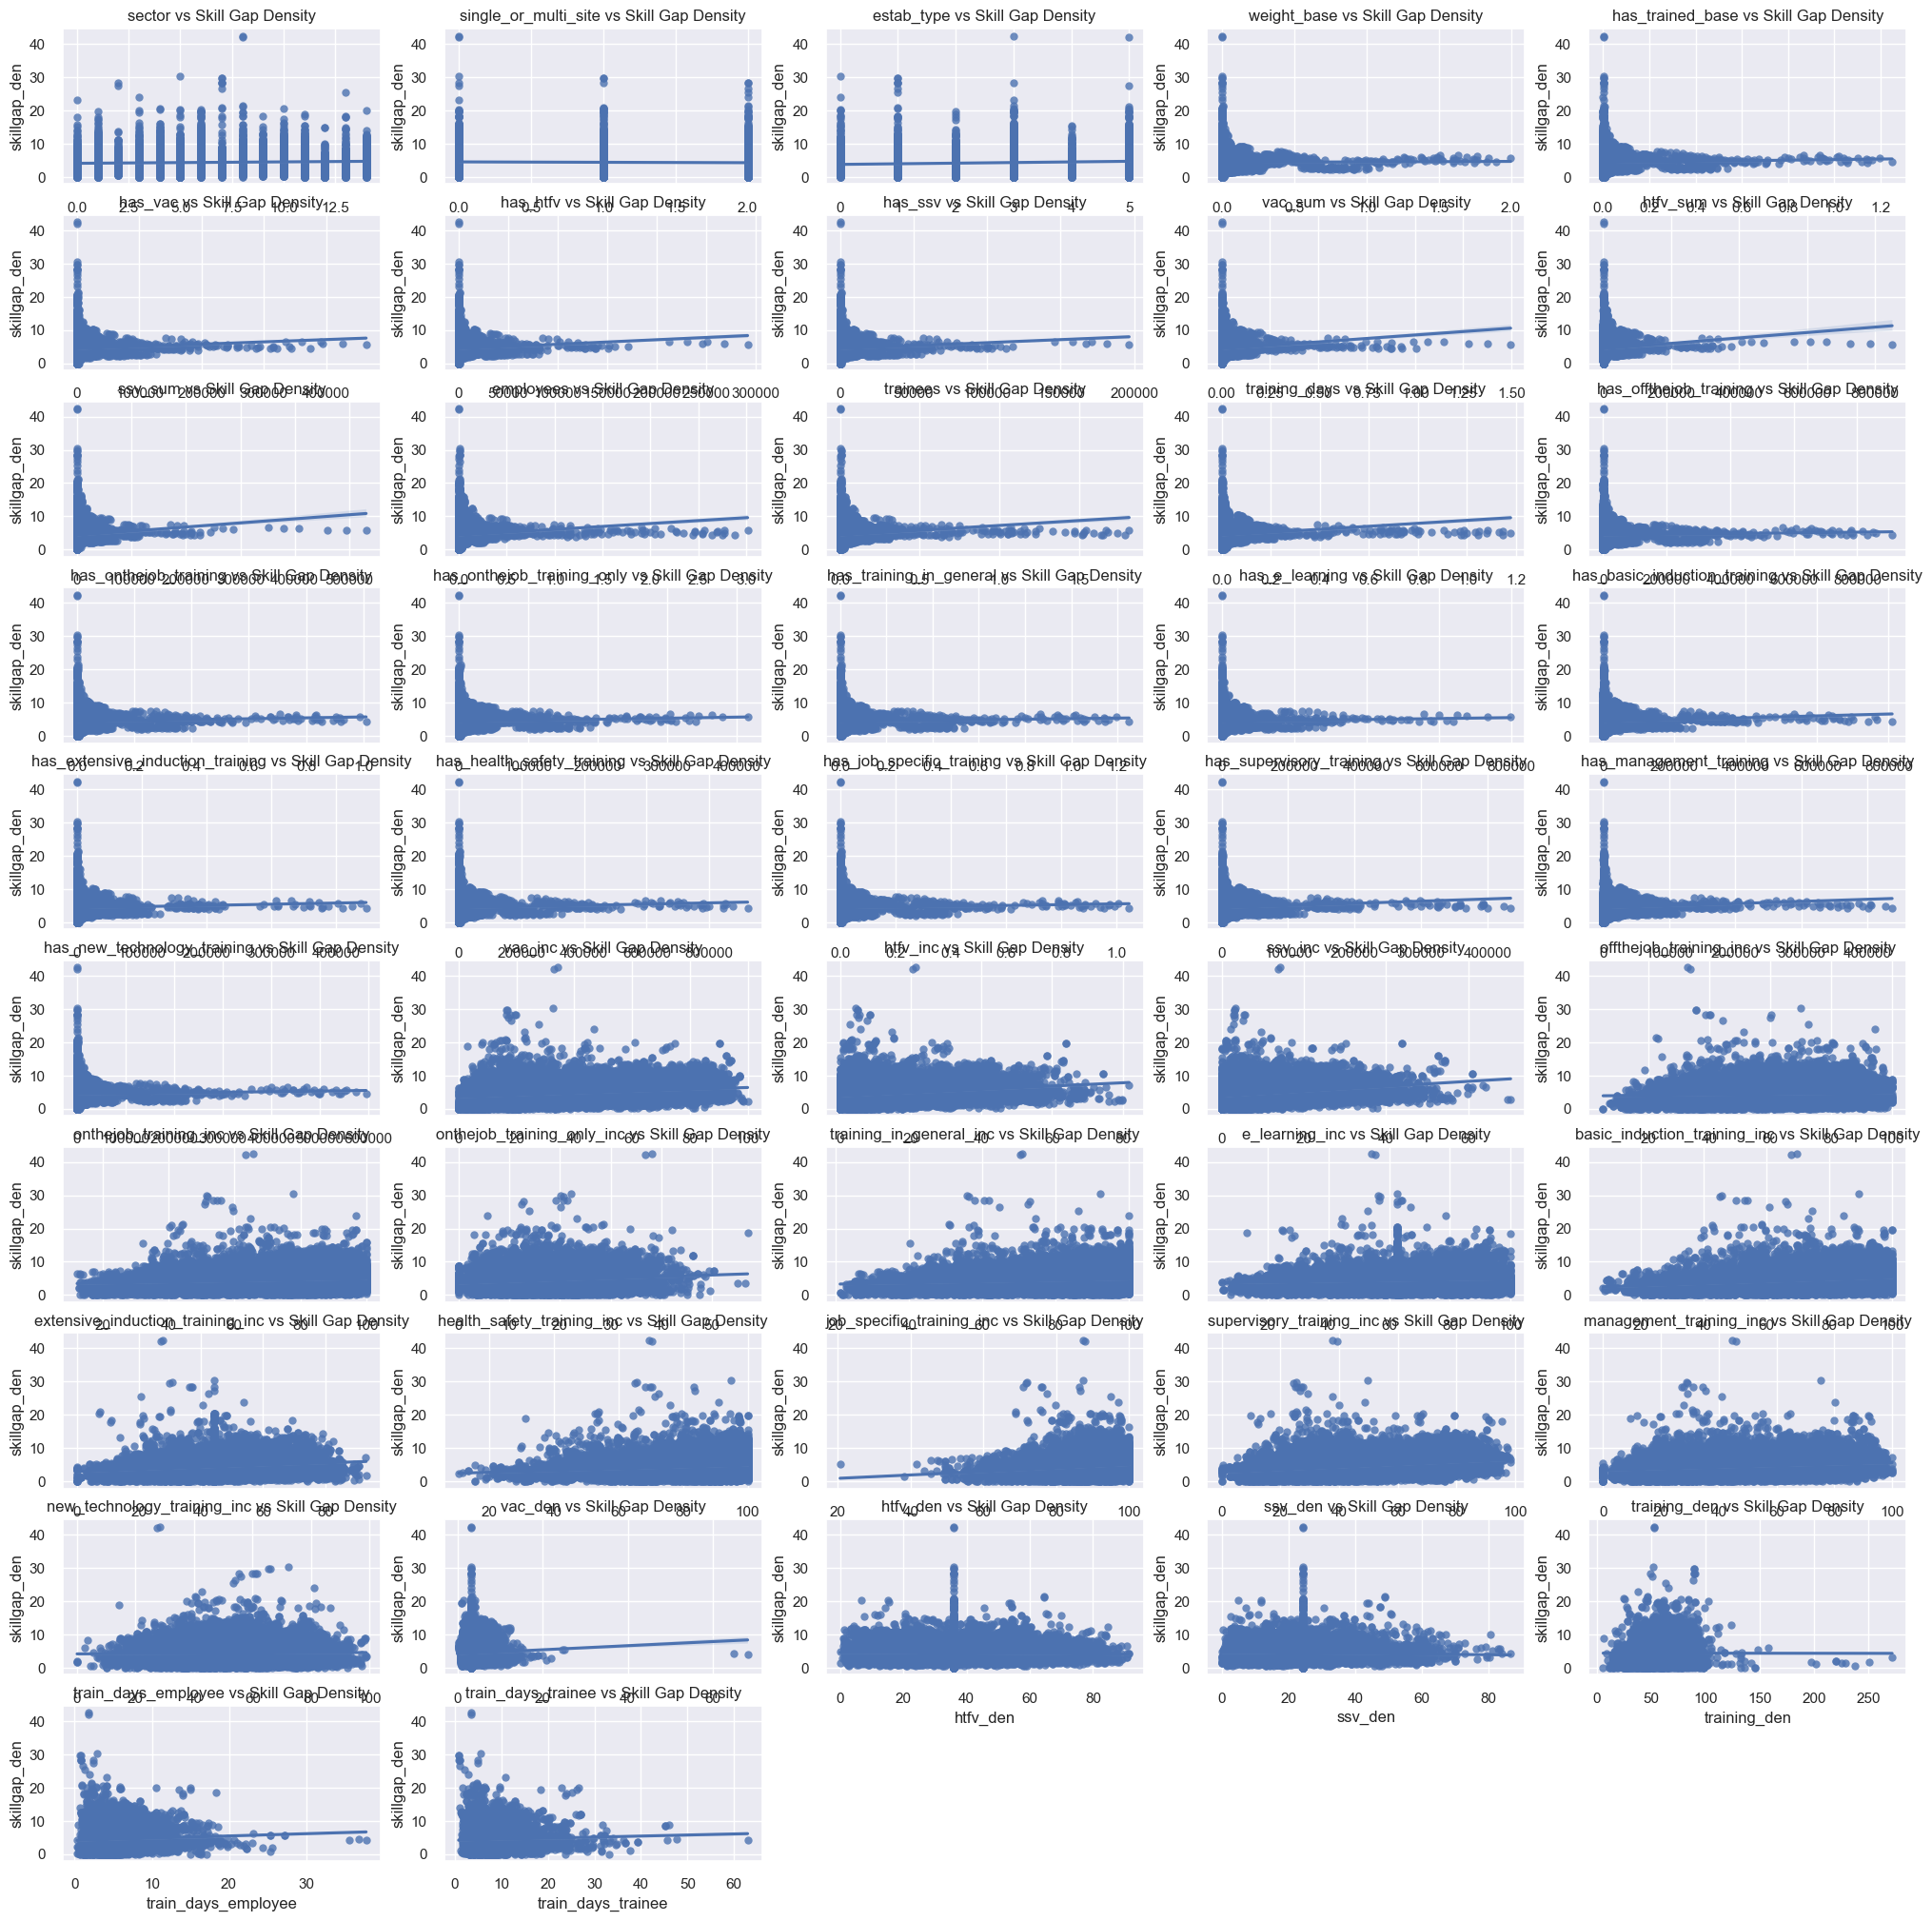

In [12]:
# To plot the relationship between predictors and Skill Gap Density
plt.figure(figsize=(25, 25))
num_features = len(X.columns)
num_rows = math.ceil(num_features / 5)
num_cols = min(5, num_features)  
for i, col in enumerate(X.columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.regplot(x=col, y=y3, data=data_copy)
    plt.title("%s vs Skill Gap Density" %(col))

In [13]:
# To calculate the VIF value for each independent variables
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# To check the vif values for multicollinearity
print(vif)

C:\Users\User\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                            Variable           VIF
0                             sector  4.090288e+00
1               single_or_multi_site  2.924514e+00
2                         estab_type  6.304327e+00
3                        weight_base  8.240344e+02
4                   has_trained_base  2.448274e+12
5                            has_vac  1.338592e+03
6                           has_htfv  1.909230e+03
7                            has_ssv  1.671269e+03
8                            vac_sum  3.125194e+02
9                           htfv_sum  7.676296e+02
10                           ssv_sum  6.307085e+02
11                         employees  4.219138e+02
12                          trainees  4.027396e+02
13                     training_days  1.900068e+02
14            has_offthejob_training           inf
15             has_onthejob_training  8.382086e+03
16        has_onthejob_training_only           inf
17           has_training_in_general  6.388085e+12
18                    has_e_lea

In [14]:
# To Calculate Pearson correlation coefficients and p-values for each independent variable
corr_pearson = {}
for column in X.columns:
    corr_coefficient, p_value = pearsonr(X[column], y1)
    corr_pearson[column] = {'pearson_coefficient': corr_coefficient, 'p_value': p_value}
    
# To Create a DataFrame from the correlation results
corr_df = pd.DataFrame(corr_pearson).T.reset_index()
corr_df.columns = ['Variable', 'Pearson Coefficient', 'P-value']

# Display the results
for column, values in corr_pearson.items():
    print(f"Variable: {column}")
    print(f"Pearson Coefficient: {values['pearson_coefficient']}")
    print(f"P-value: {values['p_value']}")
    print("---")

# To set the significant level
threshold = 0.05

# To remove the columns having p-value greater than the set significant level
columns = corr_df['Variable'][corr_df['P-value'] > threshold]

# To remove columns from the DataFrame
data_copy = X.drop(columns=columns, axis=1)
data_copy.info()

Variable: sector
Pearson Coefficient: 0.11472015262335758
P-value: 7.93174966109278e-112
---
Variable: single_or_multi_site
Pearson Coefficient: 0.028044739506601805
P-value: 4.342983989669982e-08
---
Variable: estab_type
Pearson Coefficient: 0.07765332468630379
P-value: 4.559840861311186e-52
---
Variable: weight_base
Pearson Coefficient: 0.7821802581521606
P-value: 0.0
---
Variable: has_trained_base
Pearson Coefficient: 0.8319016155863787
P-value: 0.0
---
Variable: has_vac
Pearson Coefficient: 0.8738455299878214
P-value: 0.0
---
Variable: has_htfv
Pearson Coefficient: 0.8099772944396344
P-value: 0.0
---
Variable: has_ssv
Pearson Coefficient: 0.8225382852969498
P-value: 0.0
---
Variable: vac_sum
Pearson Coefficient: 0.9399813489606479
P-value: 0.0
---
Variable: htfv_sum
Pearson Coefficient: 0.8303991665738262
P-value: 0.0
---
Variable: ssv_sum
Pearson Coefficient: 0.8537436304211055
P-value: 0.0
---
Variable: employees
Pearson Coefficient: 0.9836922151704592
P-value: 0.0
---
Variable: 

In [15]:
# To split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Evaluation metrics for 'skillgaps':
  R2 score: 0.9874
  Mean Squared Error: 36260420.1413
  Mean Absolute Error: 1413.8460
  Root Mean Squared Error: 6021.6626



C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


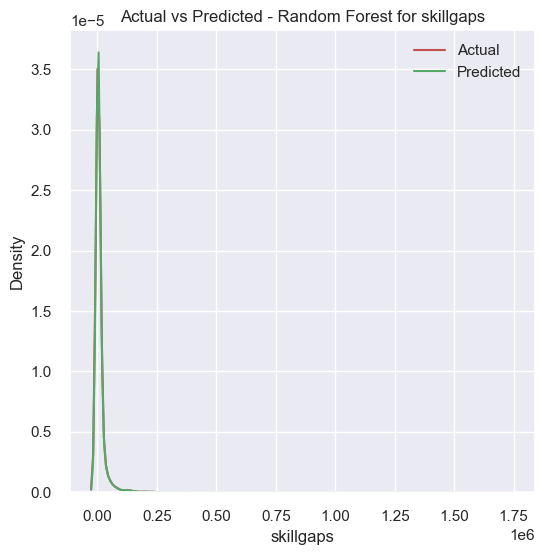

Evaluation metrics for 'skillgap_inc':
  R2 score: 0.8958
  Mean Squared Error: 17.7518
  Mean Absolute Error: 2.7496
  Root Mean Squared Error: 4.2133



C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


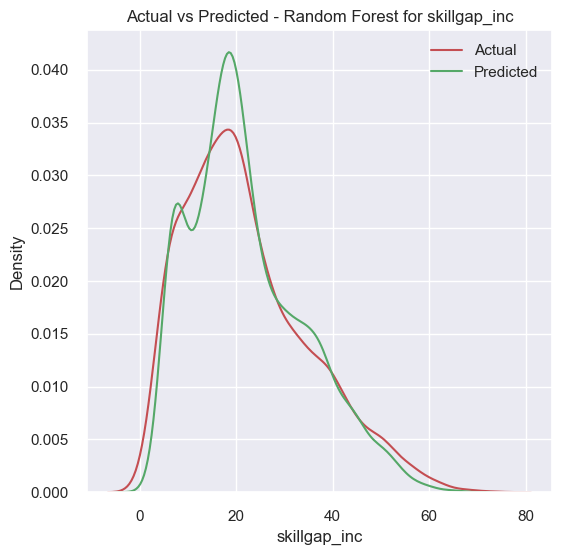

Evaluation metrics for 'skillgap_den':
  R2 score: 0.6325
  Mean Squared Error: 1.9499
  Mean Absolute Error: 0.8300
  Root Mean Squared Error: 1.3964



C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


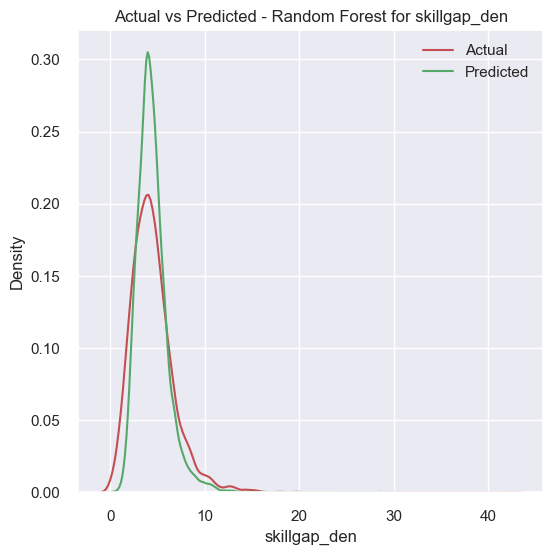

In [16]:
# To wrap RandomForest in MultiOutput Regressor 
rf_multioutput = MultiOutputRegressor(RandomForestRegressor(random_state=42))

# To fit the taining data to the model
rf_multioutput.fit(X_train, y_train)

# To predict the output on test data
y_pred_rf = rf_multioutput.predict(X_test)

# To Evaluate the model for each target variable
for i, target in enumerate(y_test.columns):
    predictions = y_pred_rf[:, i]
    actuals = y_test[target]

    # To calculate the metrics and print
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    print(f"Evaluation metrics for '{target}':")
    print(f"  R2 score: {r2:.4f}")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  Root Mean Squared Error: {rmse:.4f}\n")
    # To plot Actual vs Predicted Graph
    plt.figure(figsize=(6, 6))
    ax = sns.distplot(y_test[target], hist=False, color="r", label="Actual")
    sns.distplot(y_pred_rf[:, i], hist=False, color="g", label="Predicted", ax=ax)
    plt.title(f"Actual vs Predicted - Random Forest for {target}")
    plt.legend()
    plt.show()

Evaluation metrics for 'skillgaps':
  R2 score: 0.9922
  Mean Squared Error: 22472934.2227
  Mean Absolute Error: 1380.1707
  Root Mean Squared Error: 4740.5626



C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


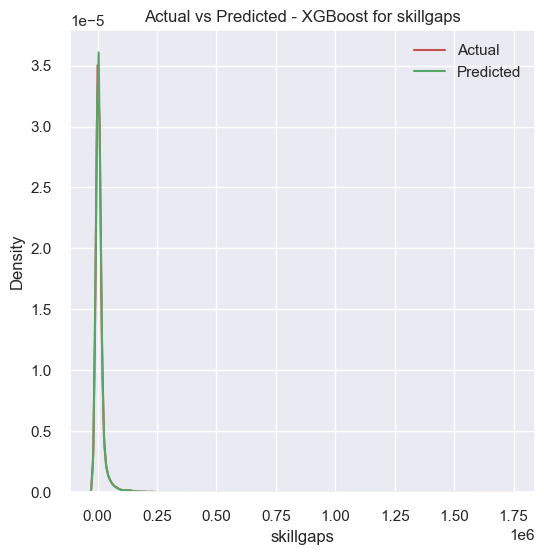

Evaluation metrics for 'skillgap_inc':
  R2 score: 0.8687
  Mean Squared Error: 22.3631
  Mean Absolute Error: 3.3269
  Root Mean Squared Error: 4.7290



C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


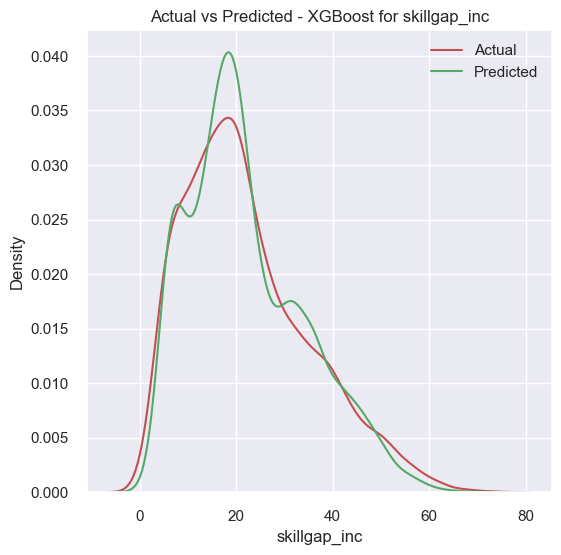

Evaluation metrics for 'skillgap_den':
  R2 score: 0.5514
  Mean Squared Error: 2.3802
  Mean Absolute Error: 1.0132
  Root Mean Squared Error: 1.5428



C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


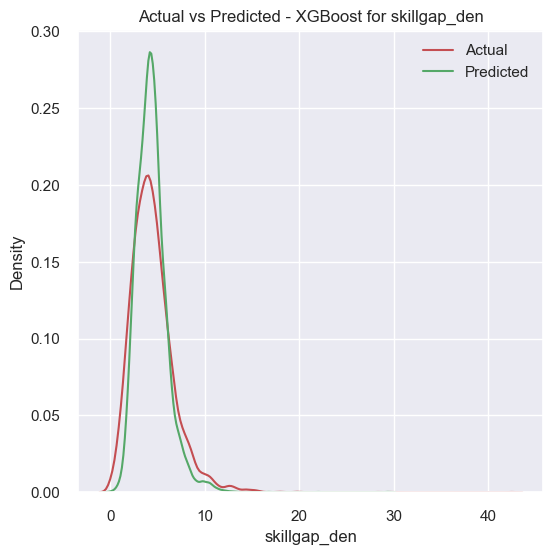

In [17]:
# To wrap XBGoost in MultiOutput Regressor
xgb_multioutput = MultiOutputRegressor(xgb.XGBRegressor(random_state=42))

# To fit the training data on the model
xgb_multioutput.fit(X_train, y_train)

# To predict the output on test data
y_pred_xgb = xgb_multioutput.predict(X_test)

# To Evaluate the model for each target variable
for i, target in enumerate(y_test.columns):
    predictions = y_pred_xgb[:, i]
    actuals = y_test[target]

    # To calculate the metrics and print
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    print(f"Evaluation metrics for '{target}':")
    print(f"  R2 score: {r2:.4f}")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  Root Mean Squared Error: {rmse:.4f}\n")
    
    # To plot Actual vs Predicted Graph
    plt.figure(figsize=(6, 6))
    ax = sns.distplot(y_test[target], hist=False, color="r", label="Actual")
    sns.distplot(y_pred_xgb[:, i], hist=False, color="g", label="Predicted", ax=ax)
    plt.title(f"Actual vs Predicted - XGBoost for {target}")
    plt.legend()
    plt.show()

Evaluation metrics for 'skillgaps':
  R2 score: 0.9815
  Mean Squared Error: 53093626.5879
  Mean Absolute Error: 1605.3539
  Root Mean Squared Error: 7286.5374



C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


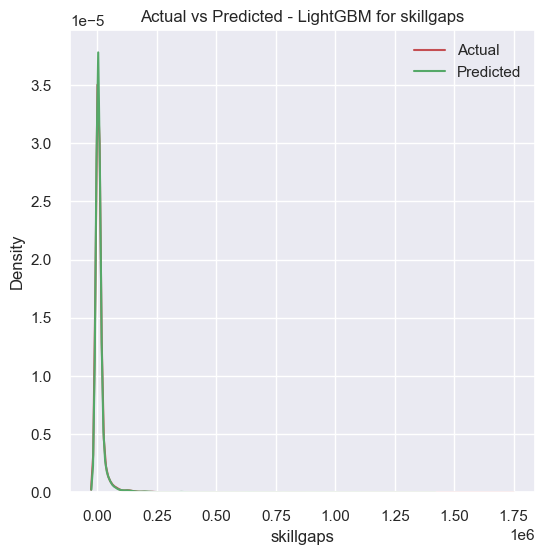

Evaluation metrics for 'skillgap_inc':
  R2 score: 0.8569
  Mean Squared Error: 24.3659
  Mean Absolute Error: 3.5608
  Root Mean Squared Error: 4.9362



C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


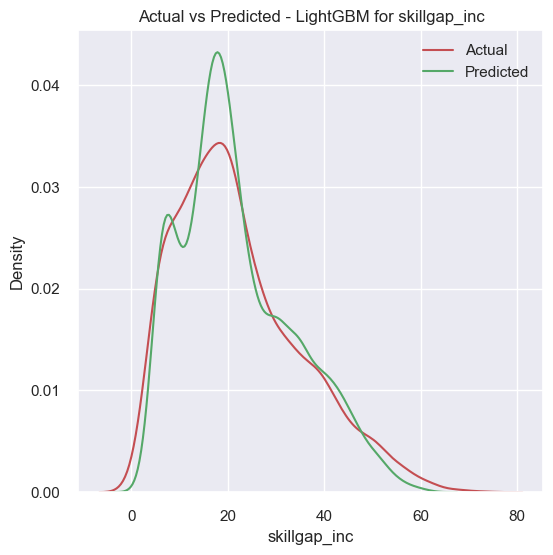

Evaluation metrics for 'skillgap_den':
  R2 score: 0.5114
  Mean Squared Error: 2.5921
  Mean Absolute Error: 1.0673
  Root Mean Squared Error: 1.6100



C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


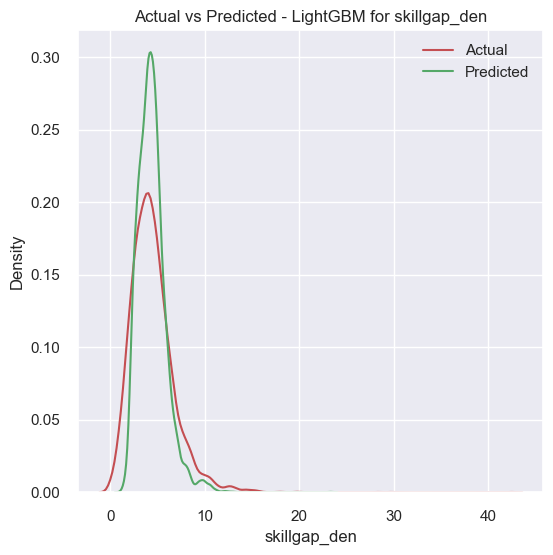

In [18]:
# To wrap LightGBM on MultiOuput Regressor
lgb_multioutput = MultiOutputRegressor(lgb.LGBMRegressor(random_state=42))

# To fit the training data on the model
lgb_multioutput.fit(X_train, y_train)

# To predict the output on test data
y_pred_lgb = lgb_multioutput.predict(X_test)

# To Evaluate the model for each target variable
for i, target in enumerate(y_test.columns):
    predictions = y_pred_lgb[:, i]
    actuals = y_test[target]

    # To calculate the metrics and print
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    print(f"Evaluation metrics for '{target}':")
    print(f"  R2 score: {r2:.4f}")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  Root Mean Squared Error: {rmse:.4f}\n")  
    # To plot Actual vs Predicted Graph
    plt.figure(figsize=(6, 6))
    ax = sns.distplot(y_test[target], hist=False, color="r", label="Actual")
    sns.distplot(y_pred_lgb[:, i], hist=False, color="g", label="Predicted", ax=ax)
    plt.title(f"Actual vs Predicted - LightGBM for {target}")
    plt.legend()
    plt.show()


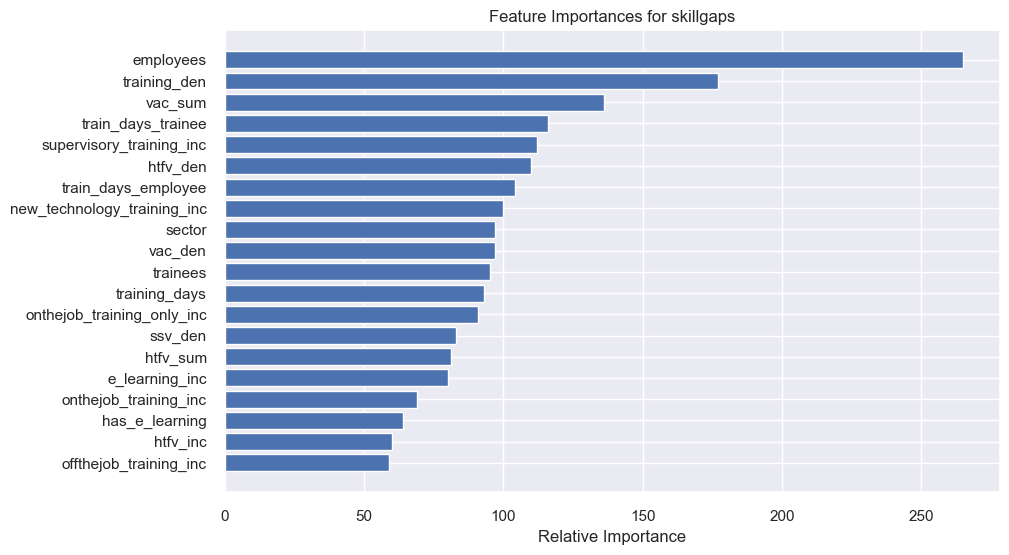

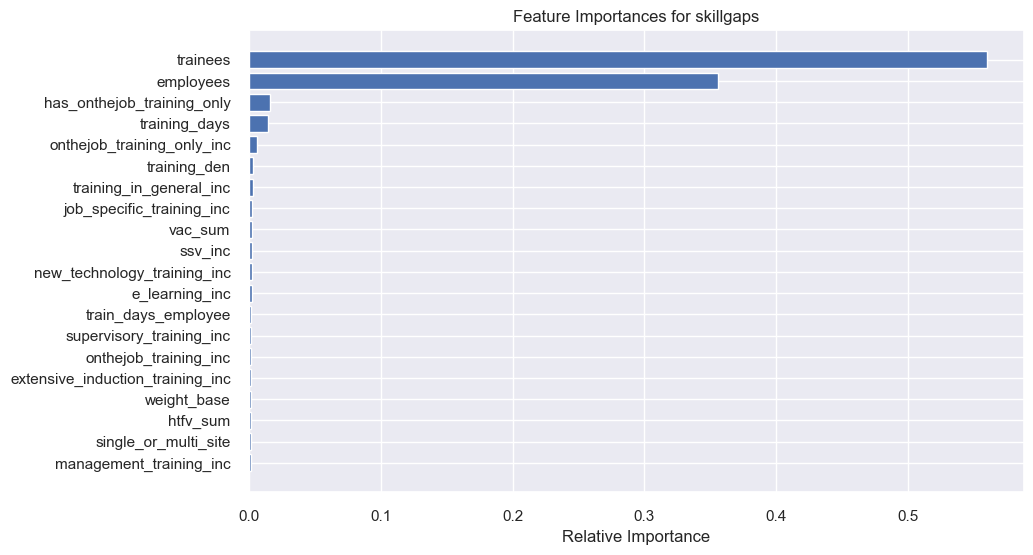

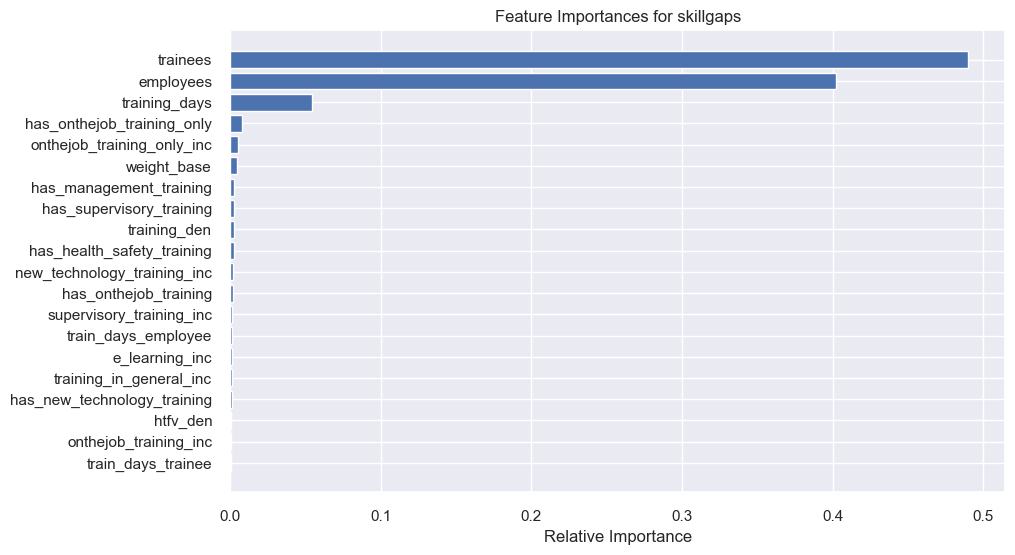

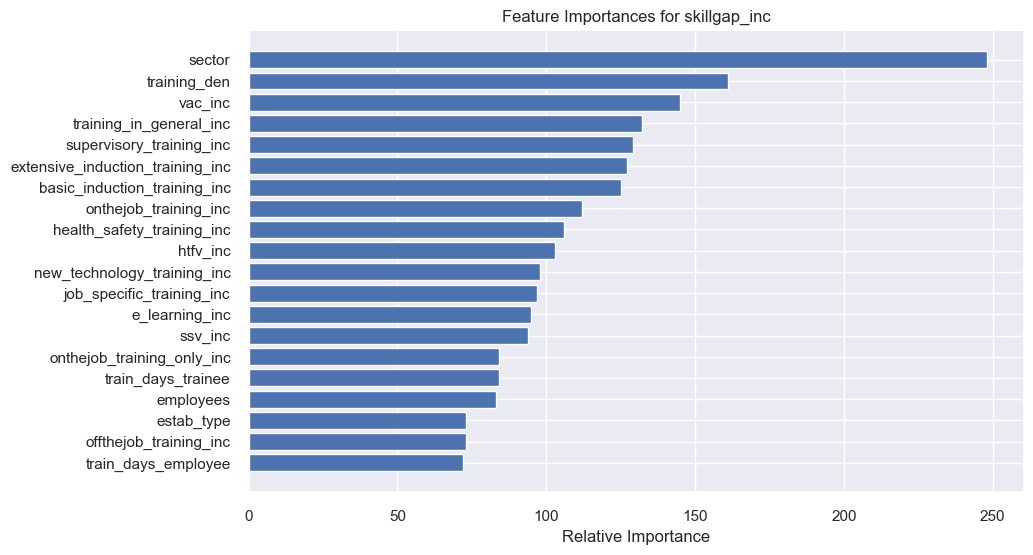

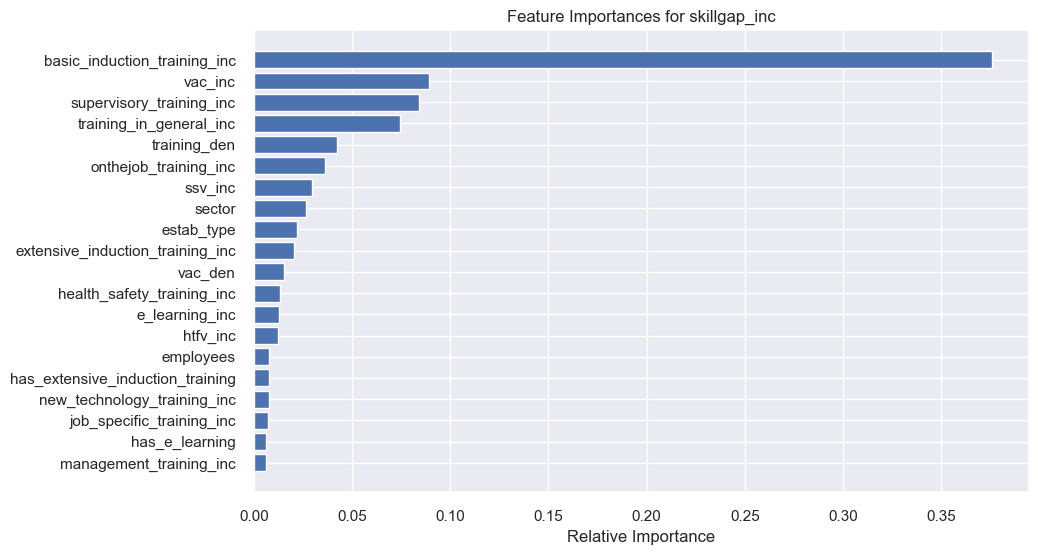

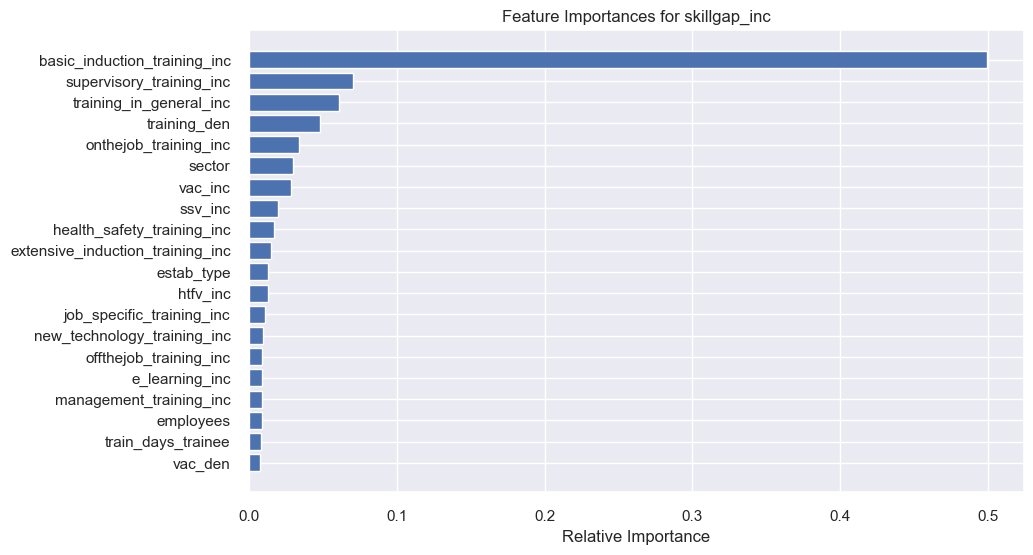

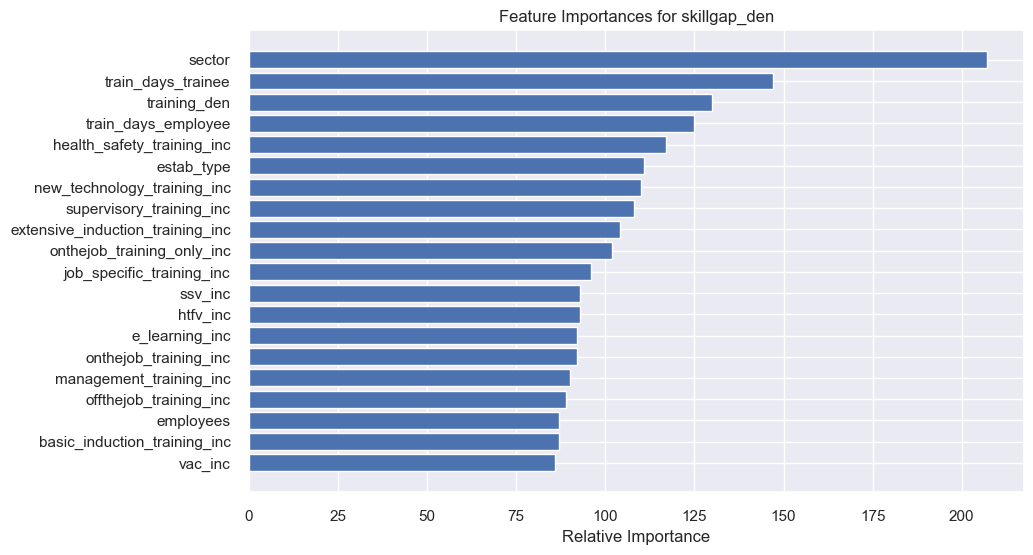

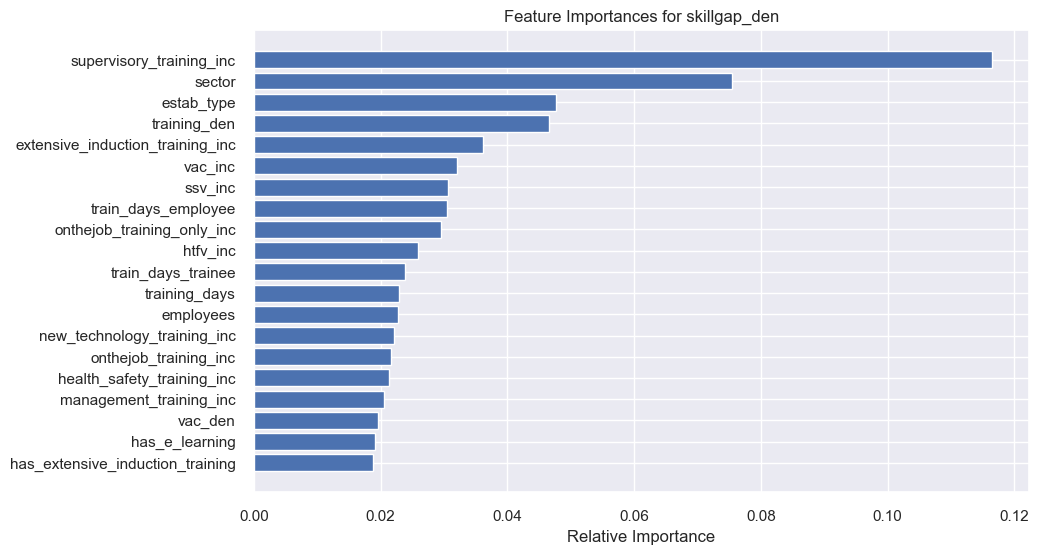

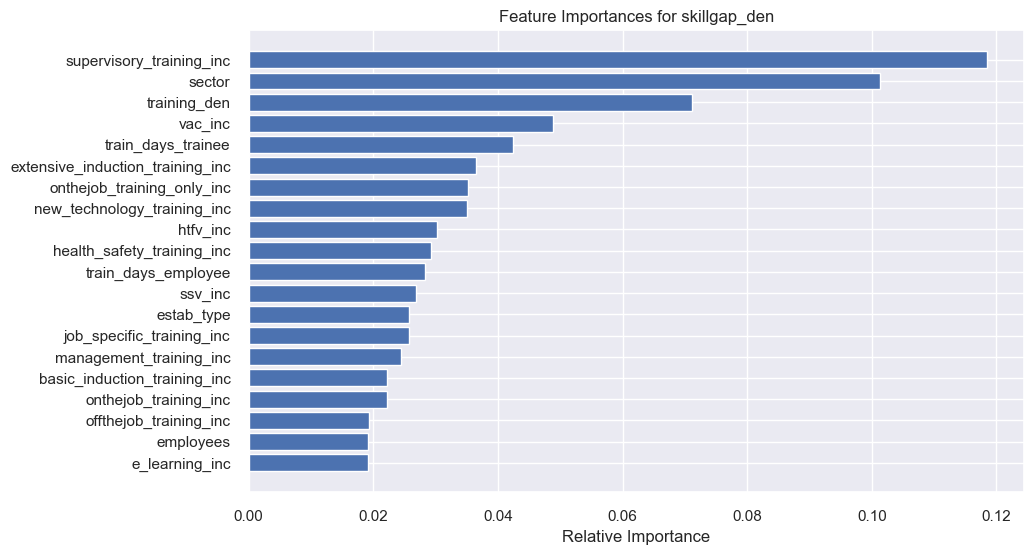

In [19]:
# To plot the feature importance for each target variable
def plot_feature_importance(model, features, target_name, num_features=20):
    # To sort the features
    importances = model.feature_importances_
    indices = np.argsort(importances)[-num_features:]
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances for {target_name}")
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
# To Plot feature importances for each target
for i, target in enumerate(y_test.columns):
    plot_feature_importance(lgb_multioutput.estimators_[i], X_train.columns, target)
    plot_feature_importance(xgb_multioutput.estimators_[i], X_train.columns, target)
    plot_feature_importance(rf_multioutput.estimators_[i], X_train.columns, target)

In [ ]:
# To define the set of parameters
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20],      
    'min_samples_split': [2, 5],      
    'min_samples_leaf': [1, 2]       
}
# To initialize GridSearch CV
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,  
    scoring='r2',
    n_jobs=-1  
)
# To fit GridSearch CV
grid_search.fit(X_train, y_train_skillgap_den)
# To print the best parameters
print("Best parameters from GridSearchCV:", grid_search.best_params_)
# To initialize the model with best parameters
rf_optimized = RandomForestRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    random_state=42
)

# To fit the optmized model
rf_optimized.fit(X_train, y_train_skillgap_den)

# To Evaluate the optimized model
r2_score_optimized = rf_optimized.score(X_test, y_test_skillgap_den)
print("Optimized Random Forest R2 score: ", r2_score_optimized)


C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


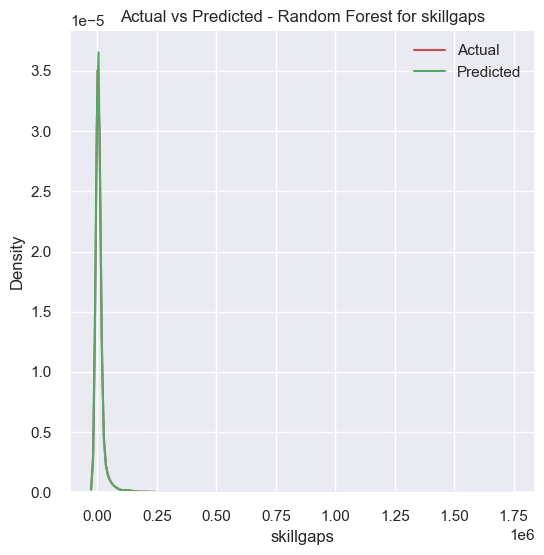

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


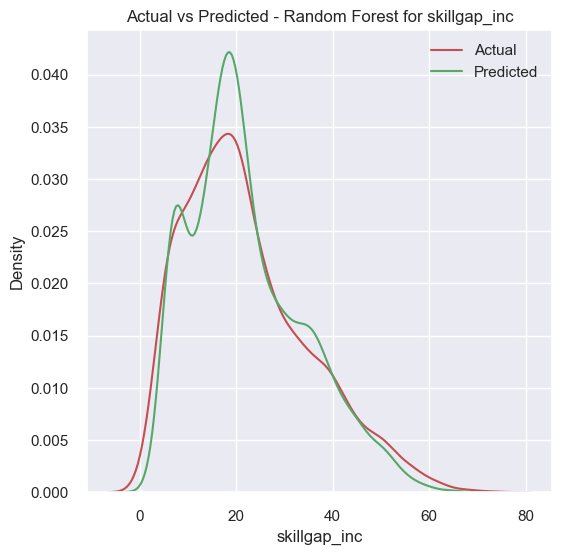

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


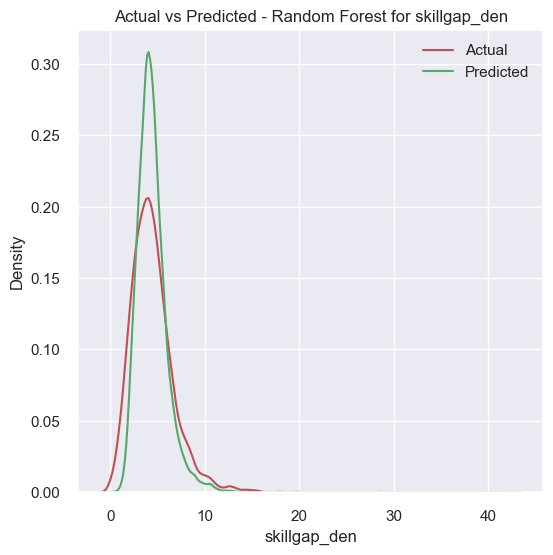

In [21]:
# To update Random Forest Regressor with the best parameters
best_params = {
    'n_estimators': 500,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_samples': 0.9,
    'max_features': 'auto',
    'max_depth': None
}

rf_optimized = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_samples=best_params['max_samples'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    random_state=42
)

rf_multioutput_optimized = MultiOutputRegressor(rf_optimized)
rf_multioutput_optimized.fit(X_train, y_train)

# To predict on the test set
y_pred_rf_optimized = rf_multioutput_optimized.predict(X_test)
# To plot Actual vs Predicted Graph
for i, target in enumerate(y_test.columns):
    plt.figure(figsize=(6, 6))
    ax = sns.distplot(y_test[target], hist=False, color="r", label="Actual")
    sns.distplot(y_pred_rf_optimized[:, i], hist=False, color="g", label="Predicted", ax=ax)
    plt.title(f"Actual vs Predicted - Random Forest for {target}")
    plt.legend()
    plt.show()